In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # ensures resampling happens inside CV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    cohen_kappa_score, matthews_corrcoef
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Dataset loading and Preprocesing (EDA, encoding, scaling)

In [3]:
df = pd.read_csv('study.csv')

print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())

Shape: (2123, 16)


,29/04/2023,gender\nstudent's sex (binary: 'F' - female or 'M' - male),age\nstudent's age (numeric: from 15 to 22),adress\nstudent's home address type (binary: 'U' - urban or 'R' - rural),famsize\nfamily size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3),Pstatus\nparent's cohabitation status (binary: 'T' - living together or 'A' - apart),M_Education,F_education,"Mjob\nmother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or other","Fjob\nfather's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or other",relationship_breakdown,smoker,avarage_tution_fee_cost,time_spent_with_friends,ssc_result,hsc_result
0,29/04/2023,M,23,U,GT3,T,2,3,other,other,yes,No,400000,4,4.39,4.33
1,29/04/2023,M,22,U,GT3,T,3,4,at_home,other,yes,yes,400000,2,4.20,4.17
2,29/04/2023,M,24,R,GT3,T,1,3,at_home,teacher,yes,yes,293000,3,3.92,4.17
3,29/04/2023,F,22,U,GT3,T,3,4,at_home,other,No,No,293000,8,5.00,5.00
4,29/04/2023,M,23,U,GT3,T,4,4,teacher,other,No,No,295000,8,4.92,4.70



Columns: ['29/04/2023', "gender\nstudent's sex (binary: 'F' - female or 'M' - male)", "age\nstudent's age (numeric: from 15 to 22)", "adress\nstudent's home address type (binary: 'U' - urban or 'R' - rural)", "famsize\nfamily size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)", "Pstatus\nparent's cohabitation status (binary: 'T' - living together or 'A' - apart)", 'M_Education', 'F_education', "Mjob\nmother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or other", "Fjob\nfather's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or other", 'relationship_breakdown', 'smoker', 'avarage_tution_fee_cost', 'time_spent_with_friends', 'ssc_result', 'hsc_result']

Missing values per column:
 29/04/2023                                                                                                                             105
gender\nstudent's sex (binary

In [4]:
df = df.rename(columns={
    "gender\nstudent's sex (binary: 'F' - female or 'M' - male)": "gender",
    "age\nstudent's age (numeric: from 15 to 22)": "age",
    "adress\nstudent's home address type (binary: 'U' - urban or 'R' - rural)": "address",
    "famsize\nfamily size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)": "fam_size",
    "Pstatus\nparent's cohabitation status (binary: 'T' - living together or 'A' - apart)": "parent_status",
    "Mjob\nmother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or other": "m_job",
    "Fjob\nfather's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or other": "f_job",
    "M_Education": "m_edu",
    "F_education": "f_edu"
})

In [5]:
df = df.drop(['29/04/2023', 'm_job', 'f_job'], axis=1)

In [6]:
df['time_spent_with_friends'] = pd.to_numeric(df['time_spent_with_friends'], errors='coerce')
mean_value = int(df['time_spent_with_friends'].mean().round())
df['time_spent_with_friends'] = df['time_spent_with_friends'].fillna(mean_value)
df['time_spent_with_friends'] = df['time_spent_with_friends'].astype(int)

In [7]:
df['parent_status'] = df['parent_status'].str.strip()
print(df['parent_status'].value_counts(dropna=False))

df['smoker'] = df['smoker'].str.strip().str.capitalize()
print(df['smoker'].value_counts(dropna=False))

df['relationship_breakdown'] = df['relationship_breakdown'].str.strip().str.capitalize()
print(df['relationship_breakdown'].value_counts(dropna=False))

parent_status
T    2028
A      95
Name: count, dtype: int64
smoker
Yes    1063
No     1060
Name: count, dtype: int64
relationship_breakdown
Yes    1232
No      891
Name: count, dtype: int64


In [8]:
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df['address'] = df['address'].map({'U': 1, 'R': 0})
df['fam_size'] = df['fam_size'].map({'LE3': 0, 'GT3': 1})
df['parent_status'] = df['parent_status'].map({'T': 1, 'A': 0})
df['relationship_breakdown'] = df['relationship_breakdown'].map({'Yes': 1, 'No': 0})
df['smoker'] = df['smoker'].map({'Yes': 1, 'No': 0})

In [9]:
def gpa_to_grade(gpa):
    if gpa >= 5.0:
        return 'A+'
    elif 4.0 <= gpa < 5.0:
        return 'A'
    elif 3.5 <= gpa < 4.0:
        return 'A-'
    elif 3.0 <= gpa < 3.5:
        return 'B'
    elif 2.0 <= gpa < 3.0:
        return 'C'
    elif 1.0 <= gpa < 2.0:
        return 'D'
    else:
        return 'F'

df['hsc_grade'] = df['hsc_result'].apply(gpa_to_grade)

In [10]:
# Define features/target (drop target-derived columns to avoid leakage)
X = df.drop(['hsc_grade', 'hsc_result'], axis=1, errors='ignore')
y = df['hsc_grade']

# Robust stratification: fallback to non-stratified if any class has <2 samples
cls_counts = y.value_counts()
if cls_counts.min() < 2:
    print("Warning: rare classes found (count<2) => using non-stratified split:", cls_counts[cls_counts < 2].to_dict())
    stratify_arg = None
else:
    stratify_arg = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_arg
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Class distribution (train):')
print(y_train.value_counts(normalize=True).round(3))

Train shape: (1698, 12) Test shape: (425, 12)
Class distribution (train):
hsc_grade
A     0.908
A-    0.054
A+    0.037
B     0.001
C     0.001
Name: proportion, dtype: float64


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

In [12]:
# %pip install shap
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
import shap

In [13]:
scalers = {
    'none': 'passthrough',
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
}

def eval_scalers_on_model(base_model, model_name='model'):
    rows = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for scaler_name, scaler in scalers.items():
        pipe = Pipeline(steps=[('scaler', scaler), ('clf', base_model)])
        f1s, accs = [], []
        for tr_idx, va_idx in cv.split(X_train, y_train):
            Xt, Xv = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            yt, yv = y_train.iloc[tr_idx], y_train.iloc[va_idx]
            pipe.fit(Xt, yt)
            yp = pipe.predict(Xv)
            f1s.append(f1_score(yv, yp, average='macro', zero_division=0))
            accs.append(accuracy_score(yv, yp))
        rows.append({'model': model_name, 'scaler': scaler_name,
                     'cv_f1_macro': np.mean(f1s), 'cv_acc': np.mean(accs)})
    return pd.DataFrame(rows).sort_values('cv_f1_macro', ascending=False).reset_index(drop=True)

print('Scaling effect on Logistic Regression')
display(eval_scalers_on_model(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE), 'LogReg'))

print('Scaling effect on SVM')
display(eval_scalers_on_model(SVC(probability=True, random_state=RANDOM_STATE), 'SVM'))

Scaling effect on Logistic Regression


,model,scaler,cv_f1_macro,cv_acc
0,LogReg,none,0.444015,0.921085
1,LogReg,standard,0.429152,0.919906
2,LogReg,robust,0.428354,0.920495
3,LogReg,minmax,0.416505,0.918138


Scaling effect on SVM


,model,scaler,cv_f1_macro,cv_acc
0,SVM,standard,0.426393,0.919323
1,SVM,robust,0.420630,0.918142
2,SVM,minmax,0.355989,0.912842
3,SVM,none,0.269699,0.908128


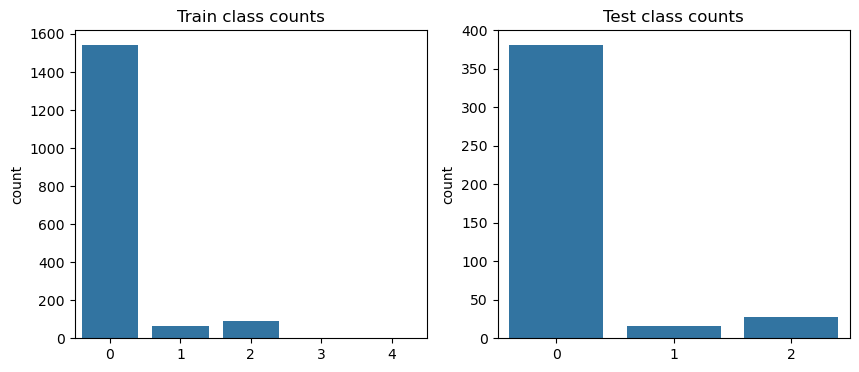

,model,accuracy,precision_macro,recall_macro,f1_macro,kappa,mcc
0,LR + Standard,0.908235,0.407840,0.402969,0.404340,0.314828,0.369700
1,LR + Standard + ROS,0.454118,0.317833,0.457138,0.285972,0.068696,0.118473


In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.countplot(x=y_train_enc, ax=ax[0]); ax[0].set_title('Train class counts')
sns.countplot(x=y_test_enc, ax=ax[1]); ax[1].set_title('Test class counts')
plt.show()

def fit_eval(pipe, name):
    pipe.fit(X_train, y_train_enc)
    yp = pipe.predict(X_test)
    out = {
        'model': name,
        'accuracy': accuracy_score(y_test_enc, yp),
        'precision_macro': precision_score(y_test_enc, yp, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test_enc, yp, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test_enc, yp, average='macro', zero_division=0),
        'kappa': cohen_kappa_score(y_test_enc, yp),
        'mcc': matthews_corrcoef(y_test_enc, yp),
    }
    try:
        yproba = pipe.predict_proba(X_test)
        if len(np.unique(y_test_enc)) > 2:
            out['roc_auc_ovr'] = roc_auc_score(y_test_enc, yproba, multi_class='ovr')
        else:
            out['roc_auc'] = roc_auc_score(y_test_enc, yproba[:,1])
    except Exception:
        pass
    return out

baseline_lr = ImbPipeline([('scaler', StandardScaler()),
                           ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
oversampled_lr = ImbPipeline([('scaler', StandardScaler()),
                              ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
                              ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])

display(pd.DataFrame([fit_eval(baseline_lr, 'LR + Standard'),
                      fit_eval(oversampled_lr, 'LR + Standard + ROS')]).sort_values('f1_macro', ascending=False))

In [15]:
def make_baseline_models():
    models = {
        'LR': ImbPipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))]),
        'SVM': ImbPipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=RANDOM_STATE))]),
        'GaussianNB': ImbPipeline([('scaler', StandardScaler()), ('clf', GaussianNB())]),
        'DecisionTree': ImbPipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
        'RandomForest': ImbPipeline([('clf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))]),
        'ExtraTrees': ImbPipeline([('clf', ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))]),
    }
    return models

def evaluate_models(models):
    return pd.DataFrame([fit_eval(m, n) for n, m in models.items()])\
             .sort_values('f1_macro', ascending=False).reset_index(drop=True)

baseline_results = evaluate_models(make_baseline_models())
display(baseline_results)

,model,accuracy,precision_macro,recall_macro,f1_macro,kappa,mcc
0,RandomForest,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
1,ExtraTrees,0.910588,0.577812,0.518209,0.539603,0.299896,0.374100
2,SVM,0.910588,0.595424,0.478292,0.511905,0.253006,0.360935
3,DecisionTree,0.851765,0.487122,0.410462,0.441536,0.213402,0.213530
4,LR,0.908235,0.407840,0.402969,0.404340,0.314828,0.369700
5,GaussianNB,0.884706,0.380964,0.426345,0.401505,0.310225,0.320113


In [16]:
def make_models_with_options(scaler_key='standard', use_ros=False):
    scaler = scalers.get(scaler_key, 'passthrough')
    models = {}
    for n, clf in {
        'LR': LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
        'SVM': SVC(probability=True, random_state=RANDOM_STATE),
        'GaussianNB': GaussianNB(),
    }.items():
        steps = [('scaler', scaler)]
        if use_ros: steps.append(('ros', RandomOverSampler(random_state=RANDOM_STATE)))
        steps.append(('clf', clf))
        models[f'{n} | {scaler_key} | ROS={use_ros}'] = ImbPipeline(steps)
    for n, clf in {
        'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'RandomForest': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    }.items():
        steps = []
        if use_ros: steps.append(('ros', RandomOverSampler(random_state=RANDOM_STATE)))
        steps.append(('clf', clf))
        models[f'{n} | none | ROS={use_ros}'] = ImbPipeline(steps)
    return models

all_rows = []
for scaler_key in ['standard', 'minmax', 'robust']:
    for use_ros in [False, True]:
        df_res = evaluate_models(make_models_with_options(scaler_key, use_ros))
        df_res.insert(0, 'config', f'scaler={scaler_key}, ROS={use_ros}')
        all_rows.append(df_res)

improvements_table = pd.concat(all_rows, ignore_index=True)
display(improvements_table.sort_values('f1_macro', ascending=False).head(20))

,config,model,accuracy,precision_macro,recall_macro,f1_macro,kappa,mcc
0,"scaler=standard, ROS=False",RandomForest | none | ROS=False,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
6,"scaler=standard, ROS=True",RandomForest | none | ROS=True,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
30,"scaler=robust, ROS=True",RandomForest | none | ROS=True,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
24,"scaler=robust, ROS=False",RandomForest | none | ROS=False,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
12,"scaler=minmax, ROS=False",RandomForest | none | ROS=False,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
18,"scaler=minmax, ROS=True",RandomForest | none | ROS=True,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
31,"scaler=robust, ROS=True",DecisionTree | none | ROS=True,0.863529,0.599941,0.553759,0.574343,0.252487,0.252835
7,"scaler=standard, ROS=True",DecisionTree | none | ROS=True,0.863529,0.599941,0.553759,0.574343,0.252487,0.252835
19,"scaler=minmax, ROS=True",DecisionTree | none | ROS=True,0.863529,0.599941,0.553759,0.574343,0.252487,0.252835
8,"scaler=standard, ROS=True",ExtraTrees | none | ROS=True,0.917647,0.608988,0.540792,0.565572,0.345146,0.442766


In [17]:
from sklearn.ensemble import StackingClassifier

ens_models = {}

ens_models['Bagging(DT)'] = ImbPipeline([
    ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
    ('clf', BaggingClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                              n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])

ens_models['RandomForest'] = ImbPipeline([
    ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1))
])

ens_models['AdaBoost(DT)'] = ImbPipeline([
    ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
    ('clf', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
                               n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE))
])

ens_models['GradientBoosting'] = ImbPipeline([
    ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
    ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

if 'XGB_AVAILABLE' in globals() and XGB_AVAILABLE:
    ens_models['XGBoost'] = ImbPipeline([
        ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
        ('clf', XGBClassifier(n_estimators=500, max_depth=4, learning_rate=0.05,
                              subsample=0.8, colsample_bytree=0.8,
                              reg_lambda=1.0, random_state=RANDOM_STATE,
                              eval_metric='logloss', n_jobs=-1))
    ])

# Stacking: AdaBoost-wrapped bases -> RF meta
def ada_wrap(clf, needs_scaling=False, scaler=StandardScaler()):
    steps = []
    if needs_scaling: steps.append(('scaler', scaler))
    steps.append(('ada', AdaBoostClassifier(estimator=clf, n_estimators=50, learning_rate=0.2,
                                            algorithm='SAMME.R', random_state=RANDOM_STATE)))
    return ImbPipeline(steps)

base_estimators = [
    ('ada_lr',  ada_wrap(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE), needs_scaling=True)),
    ('ada_svm', ada_wrap(SVC(probability=True, random_state=RANDOM_STATE), needs_scaling=True)),
    ('ada_nb',  ada_wrap(GaussianNB(), needs_scaling=True)),
    ('ada_dt',  ada_wrap(DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE))),
    ('ada_rf',  ada_wrap(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))),
    ('ada_et',  ada_wrap(ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE))),
]

ens_models['Stacking(Ada bases -> RF meta)'] = ImbPipeline([
    ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
    ('stack', StackingClassifier(
        estimators=base_estimators,
        final_estimator=RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1),
        stack_method='predict_proba',
        passthrough=False,
        n_jobs=-1
    ))
])

ensemble_results_df = pd.DataFrame([fit_eval(m, n) for n, m in ens_models.items()])\
                          .sort_values('f1_macro', ascending=False).reset_index(drop=True)
display(ensemble_results_df)

,model,accuracy,precision_macro,recall_macro,f1_macro,kappa,mcc
0,AdaBoost(DT),0.865882,0.633449,0.634468,0.633865,0.317279,0.317498
1,XGBoost,0.880000,0.602805,0.637616,0.618892,0.336811,0.337716
2,RandomForest,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627
3,Bagging(DT),0.912941,0.562784,0.598917,0.580288,0.386006,0.428036
4,GradientBoosting,0.807059,0.481897,0.507505,0.487001,0.272108,0.290092
5,Stacking(Ada bases -> RF meta),0.901176,0.633570,0.375000,0.389994,0.081318,0.207027


In [18]:
comparison = (
    pd.concat([
        baseline_results.assign(stage='baseline'),
        improvements_table.assign(stage='improvements'),
        ensemble_results_df.assign(stage='ensembles'),
    ], ignore_index=True)
    .sort_values(['f1_macro', 'accuracy'], ascending=False)
    .reset_index(drop=True)
)
display(comparison.head(25))

best_name = str(comparison.iloc[0]['model'])
print('Selected best model:', best_name)

,model,accuracy,precision_macro,recall_macro,f1_macro,kappa,mcc,stage,config
0,AdaBoost(DT),0.865882,0.633449,0.634468,0.633865,0.317279,0.317498,ensembles,NaN
1,XGBoost,0.880000,0.602805,0.637616,0.618892,0.336811,0.337716,ensembles,NaN
2,RandomForest,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,baseline,NaN
3,RandomForest | none | ROS=False,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,improvements,"scaler=standard, ROS=False"
4,RandomForest | none | ROS=True,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,improvements,"scaler=standard, ROS=True"
5,RandomForest | none | ROS=False,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,improvements,"scaler=minmax, ROS=False"
6,RandomForest | none | ROS=True,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,improvements,"scaler=minmax, ROS=True"
7,RandomForest | none | ROS=False,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,improvements,"scaler=robust, ROS=False"
8,RandomForest | none | ROS=True,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,improvements,"scaler=robust, ROS=True"
9,RandomForest,0.924706,0.587360,0.643209,0.613915,0.461812,0.519627,ensembles,NaN


Selected best model: AdaBoost(DT)


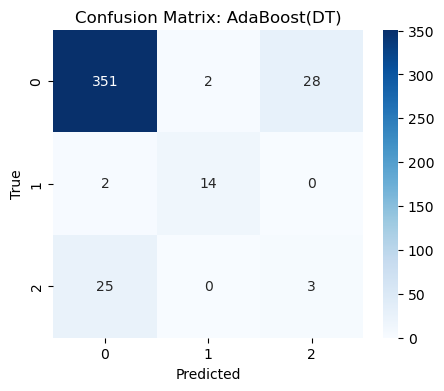

ROC-AUC not available: Number of classes in y_true not equal to the number of columns in 'y_score'
Kappa: 0.3173
MCC: 0.3175


In [26]:
def registry_all():
    reg = {}
    reg.update(make_baseline_models())
    for s in ['standard','minmax','robust']:
        reg.update(make_models_with_options(scaler_key=s, use_ros=False))
        reg.update(make_models_with_options(scaler_key=s, use_ros=True))
    reg.update(ens_models)
    return reg

best_model = registry_all()[best_name]
# best_model.fit(X_train, y_train)
best_model.fit(X_train, y_train_enc)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test_enc, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_name}')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

try:
    y_proba = best_model.predict_proba(X_test)
    if len(np.unique(y_test)) > 2:
        roc_val = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        roc_val = roc_auc_score(y_test, y_proba[:,1])
    print('ROC-AUC:', round(roc_val, 4))
except Exception as e:
    print('ROC-AUC not available:', e)

print('Kappa:', round(cohen_kappa_score(y_test_enc, y_pred), 4))
print('MCC:', round(matthews_corrcoef(y_test_enc, y_pred), 4))

PermutationExplainer explainer: 201it [17:42,  5.31s/it]                         


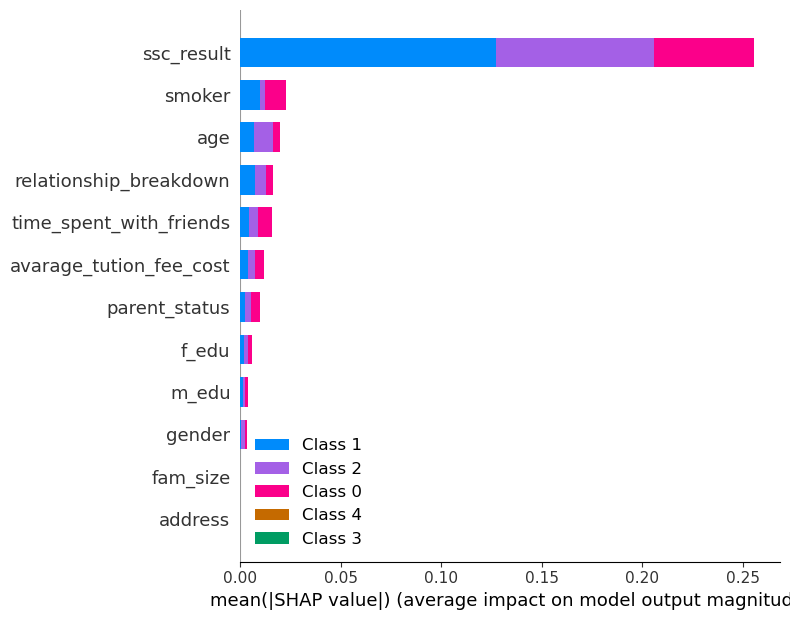

In [ ]:
X_train_s = X_train.sample(min(200, len(X_train)), random_state=RANDOM_STATE)
X_test_s  = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)

try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_test_s)
except Exception:
    explainer = shap.Explainer(lambda d: best_model.predict_proba(pd.DataFrame(d, columns=X_train.columns)),
                               X_train_s, feature_names=X_train.columns)
    shap_values = explainer(X_test_s)

shap.summary_plot(shap_values, X_test_s, show=True)

# Mean |SHAP| importance
try:
    mean_abs = np.abs(shap_values.values).mean(axis=0)
    imp = pd.Series(mean_abs, index=X_test_s.columns).sort_values(ascending=False)
    display(imp.head(20))
except Exception:
    pass

# Waterfall for one instance
try:
    shap.plots.waterfall(shap_values[0], show=True)
except Exception:
    pass

In [ ]:
print("y_train dtype:", y_train.dtype)
print("\nClass counts in y_train:")
print(y_train.value_counts().sort_index())

print("\ny_test dtype:", y_test.dtype)
print("\nClass counts in y_test:")
print(y_test.value_counts().sort_index())

y_all = pd.concat([pd.Series(y_train), pd.Series(y_test)], axis=0).reset_index(drop=True)
y_all_enc, CLASS_NAMES = pd.factorize(y_all)

# Mapping dicts
class_to_int = {cls: i for i, cls in enumerate(CLASS_NAMES)}
int_to_class = {i: cls for i, cls in enumerate(CLASS_NAMES)}

# Apply mapping to train/test
y_train_int = pd.Series(y_train).map(class_to_int).astype(int).values
y_test_int  = pd.Series(y_test).map(class_to_int).astype(int).values

print("\nEncoded classes (int -> original):")
print({i: str(lbl) for i, lbl in int_to_class.items()})

print("\nUnique codes in y_train_int:", np.unique(y_train_int))
print("Unique codes in y_test_int:", np.unique(y_test_int))

# Quick contiguity check
def check_contiguous(codes):
    u = np.unique(codes)
    expected = np.arange(u.min(), u.min()+len(u))
    print("Contiguous 0..K-1:" if np.array_equal(u, np.arange(len(u))) else f"Non-contiguous codes found: {u}")

check_contiguous(y_train_int)
check_contiguous(y_test_int)

y_train dtype: object

Class counts in y_train:
hsc_grade
A     1542
A+      62
A-      91
B        2
C        1
Name: count, dtype: int64

y_test dtype: object

Class counts in y_test:
hsc_grade
A     381
A+     16
A-     28
Name: count, dtype: int64

Encoded classes (int -> original):
{0: 'A', 1: 'A+', 2: 'A-', 3: 'C', 4: 'B'}

Unique codes in y_train_int: [0 1 2 3 4]
Unique codes in y_test_int: [0 1 2]
Contiguous 0..K-1:
Contiguous 0..K-1:


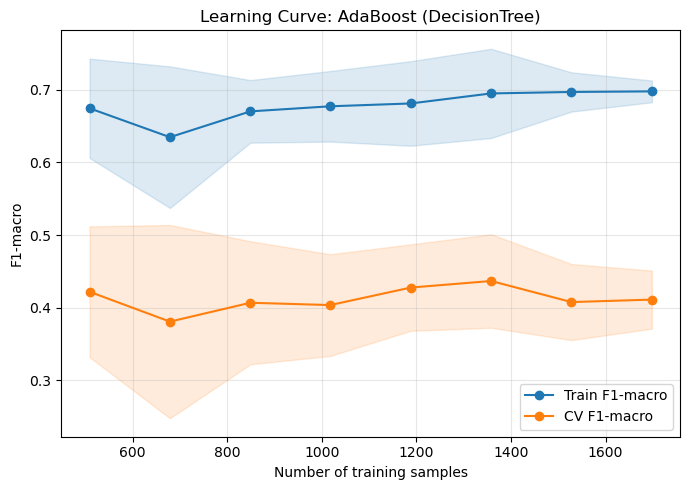

Train sizes: [ 509  679  849 1018 1188 1358 1528 1698]
Train F1 (mean±std): [0.675 0.635 0.67  0.677 0.681 0.695 0.697 0.698] ± [0.068 0.097 0.043 0.049 0.058 0.061 0.027 0.015]
CV F1 (mean±std):    [0.422 0.381 0.407 0.404 0.428 0.437 0.408 0.411] ± [0.09  0.133 0.085 0.07  0.06  0.064 0.052 0.04 ]


In [23]:
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import RandomOverSampler

# Toggle ROS inside the learning-curve pipeline (may fail for tiny training sizes if a class is absent)
USE_ROS_FOR_LC = False

# Build estimator (match your earlier AdaBoost(DT) config)
ada_dt = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
    n_estimators=300,
    learning_rate=0.05,
    random_state=RANDOM_STATE
)

if USE_ROS_FOR_LC:
    est = ImbPipeline([
        ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
        ('clf', ada_dt)
    ])
else:
    est = Pipeline([
        ('clf', ada_dt)
    ])

# CV and train sizes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
train_sizes = np.linspace(0.3, 1.0, 8)  # start at 30% to reduce rare-class issues

# Compute learning curve using macro F1
ts, train_scores, val_scores = learning_curve(
    estimator=est,
    X=X, y=y, cv=cv,
    train_sizes=train_sizes,
    scoring='f1_macro',
    n_jobs=-1,
    shuffle=True,
    random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(ts, train_mean, 'o-', label='Train F1-macro', color='C0')
plt.fill_between(ts, train_mean-train_std, train_mean+train_std, color='C0', alpha=0.15)
plt.plot(ts, val_mean, 'o-', label='CV F1-macro', color='C1')
plt.fill_between(ts, val_mean-val_std, val_mean+val_std, color='C1', alpha=0.15)
plt.title('Learning Curve: AdaBoost (DecisionTree)')
plt.xlabel('Number of training samples')
plt.ylabel('F1-macro')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print('Train sizes:', ts)
print('Train F1 (mean±std):', np.round(train_mean, 3), '±', np.round(train_std, 3))
print('CV F1 (mean±std):   ', np.round(val_mean, 3),   '±', np.round(val_std, 3))

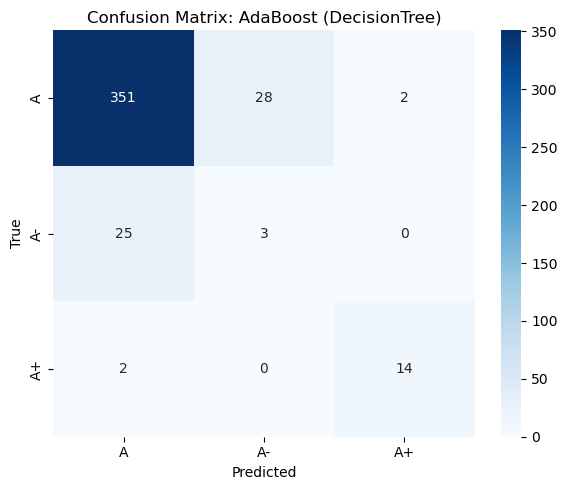

Kept 425 of 425 test samples.
Encoded classes (int -> original): {0: 'A', 2: 'A-', 1: 'A+'}


In [28]:
if 'int_to_class' not in globals() or 'y_train_int' not in globals() or 'y_test_int' not in globals():
    y_all = pd.concat([pd.Series(y_train), pd.Series(y_test)], axis=0).reset_index(drop=True)
    y_all_enc, CLASS_NAMES = pd.factorize(y_all)
    class_to_int = {cls: i for i, cls in enumerate(CLASS_NAMES)}
    int_to_class = {i: cls for i, cls in enumerate(CLASS_NAMES)}
    y_train_int = pd.Series(y_train).map(class_to_int).astype(int).values
    y_test_int  = pd.Series(y_test).map(class_to_int).astype(int).values

ada_dt = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
    n_estimators=300,
    learning_rate=0.05,
    random_state=RANDOM_STATE
)
pipe_ada = ImbPipeline([
    ('ros', RandomOverSampler(random_state=RANDOM_STATE)),
    ('clf', ada_dt)
])
pipe_ada.fit(X_train, y_train_int)
y_pred_int = pipe_ada.predict(X_test)

inv_map = {lbl: idx for idx, lbl in int_to_class.items()}
allowed_names = ['A', 'A-', 'A+']  # order as requested
allowed_idx = [inv_map[c] for c in allowed_names if c in inv_map]
ticklabels = [c for c in allowed_names if c in inv_map]

mask_keep = np.isin(y_test_int, allowed_idx) & np.isin(y_pred_int, allowed_idx)
y_test_sub = y_test_int[mask_keep]
y_pred_sub = y_pred_int[mask_keep]

cm = confusion_matrix(y_test_sub, y_pred_sub, labels=allowed_idx)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ticklabels, yticklabels=ticklabels)
plt.title('Confusion Matrix: AdaBoost (DecisionTree)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

print(f"Kept {mask_keep.sum()} of {len(y_test_int)} test samples.")
print("Encoded classes (int -> original):", {i: int_to_class[i] for i in allowed_idx})